## Data preparation and sanitization - Treatment t00

In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

from core.utils.preprocessing import df_to_xydf, df_to_xy

TREATMENT = "t00"
export_folder = f"../data/output/diagrams/{TREATMENT}"
os.makedirs(export_folder, exist_ok=True)

# Read and sanitize the data
df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


In [2]:
df_full[["offer", "offer_final", "min_offer"]].describe()

,offer,offer_final,min_offer
count,103.000000,103.000000,103.000000
mean,43.592233,43.592233,40.679612
std,14.974119,14.974119,18.445050
min,0.000000,0.000000,0.000000
25%,40.000000,40.000000,35.000000
50%,50.000000,50.000000,45.000000
75%,50.000000,50.000000,50.000000
max,100.000000,100.000000,100.000000


In [3]:
import seaborn as sns
from core.utils.preprocessing import df_to_xydf, df_to_xy
# Correlation Matrix Heatmap
CORRELATION_THRESHOLD = 0.15


corr_min_offer = df.corr()["min_offer"]
corr_columns = corr_min_offer[abs(corr_min_offer)>=CORRELATION_THRESHOLD].keys()
select_columns = [col for col in corr_columns if col != "min_offer"]

df_x, df_y = df_to_xydf(df=df, select_columns=select_columns)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']

corr = df_corr.corr()

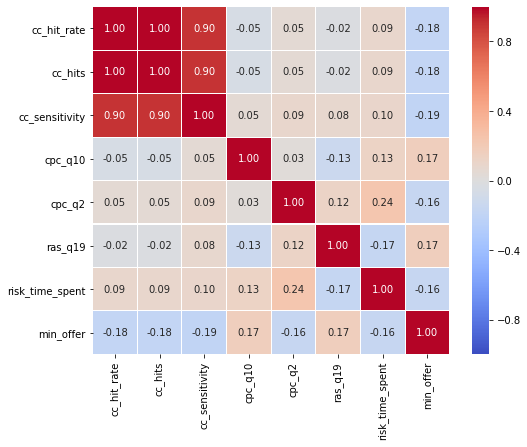

In [29]:
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05, vmax=1, vmin=-1)
f.subplots_adjust(top=0.93)
# t= f.suptitle(f'Features with abs(features to min_offer correlation) >= {CORRELATION_THRESHOLD}', fontsize=14)

# f.savefig(os.path.join(export_folder, "features_correlation.pdf"))
# print(corr["min_offer"].T.to_latex())

**Responder's min_offer / Proposer's over and final_offer distribution**

**Responder minimum offer and proposer offer**

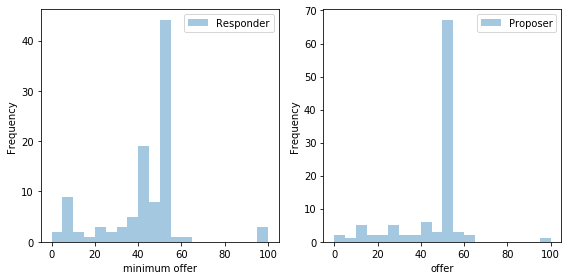

In [5]:

bins = list(range(0, 105, 5))
f, axes = plt.subplots(1, 2, figsize=(8,4))
ax = sns.distplot(df["min_offer"], hist=True, kde=False, axlabel="minimum offer", label="Responder", bins=bins, ax=axes[0])
ax.legend(loc='best')
_ = ax.set_ylabel("Frequency")

ax = sns.distplot(df_full["offer_final"], hist=True, kde=False, axlabel="offer", label="Proposer", bins=bins, ax=axes[1])
_ = ax.set_ylabel("Frequency")
ax.legend(loc='best')

plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.pdf"))

**Proposer offer - Responder minoffer**

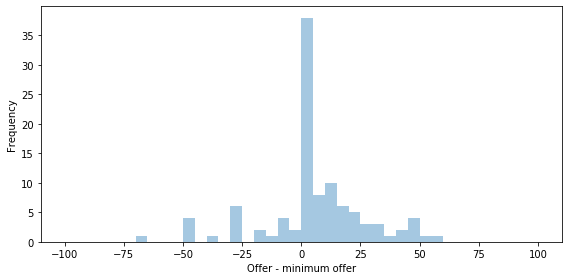

In [6]:
bins = list(range(-100, 105, 5))

plt.figure(figsize=(8,4))
offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="Offer - minimum offer", bins=bins)
_ = ax.set_ylabel("Frequency")
plt.tight_layout()
ax.figure.savefig(os.path.join(export_folder, "offer-min_offer.pdf"))

**Proposer offer distribution**

In [7]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain_mean, rejection_ratio, loss_sum, MAX_GAIN

def get_infos(min_offer, offer, metrics=None, do_cross_compute=False):
    if metrics is None:
        metrics = [avg_gain_ratio, gain_mean, rejection_ratio, loss_sum]
    #df = pd.DataFrame()
    infos = dict()
    for idx, metric in enumerate(metrics):
        if do_cross_compute:
            infos[metric.__name__] = cross_compute(min_offer, offer, metric)
        else:
            infos[metric.__name__] = metric(min_offer, offer)

    return infos

In [8]:


df_infos = pd.DataFrame()
#Human (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer']), ignore_index=True)
#Human (cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final'], do_cross_compute=True), ignore_index=True)
#Top-model (fixed 50% prediction) average performance t00
fixed_offer = MAX_GAIN // 2
df_infos = df_infos.append(get_infos(df_full['min_offer'], [fixed_offer], do_cross_compute=True), ignore_index=True)

df_infos.index = ["Proposer", "Proposer (cross matched)", "AI-System"]
df_infos = df_infos.loc[["Proposer", "AI-System"]]
df_infos

,avg_gain_ratio,gain_mean,loss_sum,rejection_ratio
Proposer,0.682297,41.116505,1875.0,0.203883
AI-System,0.813006,47.572816,1210.0,0.048544
